In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label

In [9]:
def get_theta(coef, x):
    theta = 0.0
    for i in range(0, len(x)):
        theta = theta + (coef[i] * x[i])
    return theta


# This function returns the prediction based on the output of
# theta
def get_prediction(theta):
    prediction = 1 / (1 + np.exp(-theta))
    return prediction

# Takes array of coefficients previously used, the dependent
# variable values, the predicted value, the alpha, which
# will default to 0.3, and the array of x values
# This function will calculate the new coefficients and return
# them in the form of an array

def update_coef(coef_array, x_array, y, prediction, alpha):
    new_coef = []
    for i in range(0, len(x_array)):
        coef = coef_array[i] + alpha * (y - prediction) * prediction * (1 - prediction) * x_array[i]
        new_coef.append(coef)
    return new_coef

# Takes array
# Takes an array of x values, an array of coefficients,a "y"
# value and an alpha value, builds the theta value runs theta
# through the sigmoid function and runs that through the
# gradient descent algorithm, update_coef and returns an
# array of coefficients which will be used by the model with
# the non-training data.

def initialize_model(train_row, y, learning_rate):
    # initialize coefficient array with all 0.0
    initial_coef = []
    for i in range(0, len(train_row)):
        initial_coef.append(0.0)
    x_vals = train_row
    y = y
    theta = get_theta(initial_coef, x_vals)
    prediction = get_prediction(theta)
    return update_coef(initial_coef, x_vals, y, prediction, learning_rate)

# Takes independent variables as array, coefficients as array,
# dependent variabls as array, and a learning rate as a float
# Generates theta value using coefficients
def build_model_epoch(independent_variables, coef, dependent_variables, learning_rate):

    coefficients = coef
    predictions = []
    for i in range(0, len(independent_variables)):
        theta = get_theta(coefficients, independent_variables[i])
        prediction = get_prediction(theta)
        coefficients = update_coef(coefficients, independent_variables[i], \
                                        dependent_variables[i], prediction, learning_rate)
        if prediction < 0.5:
            predictions.append(0)
        else:
            predictions.append(1)
            
    score = get_score(get_raw_test_results(predictions, dependent_variables))
    

    return coefficients, score

def build_model(learning_rate, epoch_count, independent_variables, dependent_variables):
    coefficients = initialize_model(independent_variables[0], dependent_variables[0], learning_rate)
    scores = []
    for i in range(0, epoch_count):
        coefficients, score = build_model_epoch(independent_variables, coefficients, dependent_variables,
                                              learning_rate)
        scores.append(score)

    return coefficients, scores


def test_model(model_coef, test_inde_vars):
    coef = model_coef
    predictions = []
    for i in range(0, len(test_inde_vars)):
        theta = get_theta(coef, test_inde_vars[i])
        prediction = get_prediction(theta)
        if prediction < 0.5:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions

def get_raw_test_results(test, y_vals_test):
    one_is_one = 0
    zero_is_zero = 0
    one_is_zero = 0
    zero_is_one = 0

    for i in range(0, len(test)):
        
        if test[i] == 1 and y_vals_test[i] == 1:
            one_is_one += 1
        elif test[i] == 0 and y_vals_test[i] == 0:
            zero_is_zero += 1
        elif test[i] == 0 and y_vals_test[i] == 1:
            one_is_zero += 1
        else:
            zero_is_one += 1
        raw_test_results = [one_is_one, zero_is_zero, one_is_zero, zero_is_one]
    return raw_test_results

def get_score(raw_score_array):
    total = 0
    for score in range(0, len(raw_score_array)):
        total = total + raw_score_array[score]
    total_correct = raw_score_array[0] + raw_score_array[1]
    score = total_correct / total * 100
    return score

def get_numeric_features(df):
    features_list = list(set(df.columns) - {'target'})
    numeric_cols = []
    for feature in features_list:
        if (df.dtypes[feature]  == 'int64' or df.dtypes[feature]  == 'float64'\
        or df.dtypes[feature]  == 'int' or df.dtypes[feature]  == 'float')\
        and len(pd.unique(df[feature])) > 5:
            numeric_cols.append(feature)
    return numeric_cols

def get_features_and_target_arrays(df, numeric_cols, cat_cols, scaler):
    X_numeric_scaled = scaler.transform(df[numeric_cols])
    X_categorical = df[cat_cols].to_numpy()
    X_placeholder = df[['placeholder']].to_numpy()
    X = np.hstack((X_placeholder, X_categorical, X_numeric_scaled))
    y = df['target'].to_numpy()
    return X, y

def get_drop_cols(df, numeric_cols, cat_cols):
    drop_cols = list(set(df.columns) - set(numeric_cols) - set(cat_cols) - {'target'})
    return(drop_cols)
    

In [3]:
dataset = 'Default_Fin.csv'
df = pd.read_csv(dataset, na_values='?')
df = df.rename(columns={df.columns.values[-1]:'target'})
df = df.dropna().copy()
numeric_features_list = get_numeric_features(df)
cat_features_list = list(set(df.columns) - set(numeric_features_list) - {'target'})
cat_features_list.sort()
numeric_column_selector = widgets.SelectMultiple(
                    options=numeric_features_list,
                    #rows=10,
                    description='Numeric Features',
                    disabled=False
                  )
cat_column_selector = widgets.SelectMultiple(
                    options=cat_features_list,
                    #rows=10,
                    description='Cagegorical Features',
                    disabled=False
                  )
display(numeric_column_selector)
display(cat_column_selector)

SelectMultiple(description='Numeric Features', options=('Bank Balance', 'Index', 'Annual Salary'), value=())

SelectMultiple(description='Cagegorical Features', options=('Employed',), value=())

In [4]:
cat_cols = list(cat_column_selector.value)
numeric_cols = list(numeric_column_selector.value)
drop_cols = get_drop_cols(df, numeric_cols, cat_cols)
df = df.drop(drop_cols, axis=1)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
cat_cols = list(set(df.columns) - set(numeric_features_list) - {'target'})

In [5]:
df.insert(loc=0, column="placeholder", value=np.ones(len(df.iloc[:,0])))
random_seed = 582
df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed, stratify=df['target'])
scaler = MinMaxScaler()
scaler.fit(df_train[numeric_cols])

X, y = get_features_and_target_arrays(df_train, numeric_cols, cat_cols, scaler)

In [25]:
model, epoch_scores = build_model(1, 10, X, y)

In [26]:
x_test, y_test = get_features_and_target_arrays(df_test, numeric_cols, cat_cols, scaler)

In [27]:
test = test_model(model, x_test)

In [28]:
raw_score = get_raw_test_results(test, y_test)
print(raw_score)
score = get_score(raw_score)
print(score)

[18, 1917, 49, 16]
96.75


Text(0.5, 0, 'Epoch Count')

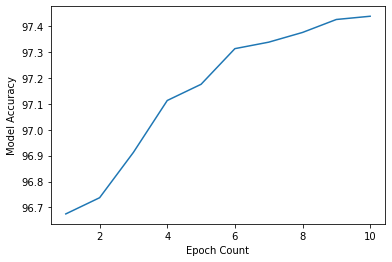

In [29]:
plt.plot(np.linspace(1,10, 10),epoch_scores)
plt.ylabel('Model Accuracy')
plt.xlabel('Epoch Count')